# Time-dependent Schrödinger Equation

Consider the time-dependent one-dimensional quantum harmonic oscillator defined by the Hamiltonian:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{\omega^2}{2m} \left( \hat{q} - q_0(t) \right)^2, \qquad \qquad \text{where} \quad q_0(t) = \frac{t}{T}, \quad t \in [0, T].

$$

Given the initial state as the ground state of the harmonic oscillator $ |\Psi_0\rangle = |n = 0\rangle $, compute the time-evolved wavefunction $|\Psi(t)\rangle$ for different <br> values of $T$. Plot the square norm of $|\Psi(t)\rangle$ as a function of $q$ at different times, and the average position of the particle as a function of $t$.


In [1]:
import functions as fu
import animation as anim

import numpy as np

## Parameters and Initial Conditions

In [ ]:
# SIMULATION PARAMETERS

L = 10
xmin = -L
xmax = L
num_x = 1000
tsim = 10       # T
num_t = 1000    # time_steps

# dt = 0.001
# num_t = int(tsim / dt)

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 1.0
order = 8
n = 10
q0_func = lambda t: t / tsim 

## Real time evolution

In [3]:
im_time = False

In [4]:
# Initialize the Param object
par = fu.Param(xmin, xmax, num_x, tsim, num_t, im_time)



# Initialize the Operators object
opr = fu.Operators(res, voffset, wfcoffset, omega, order, n, q0_func, par)

In [5]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 0.5000000000000099


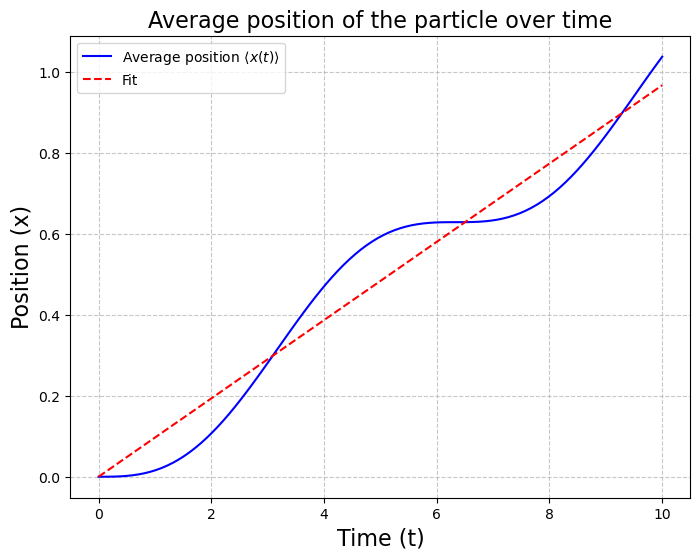

In [6]:
# Run the simulation and get the results
density, potential, avg_position = fu.split_op(par, opr)

filename = f"n={n}_real_T={tsim}.png"

popt, fitted_curve = anim.plot_average_position(par, avg_position, n, filename, im_time)

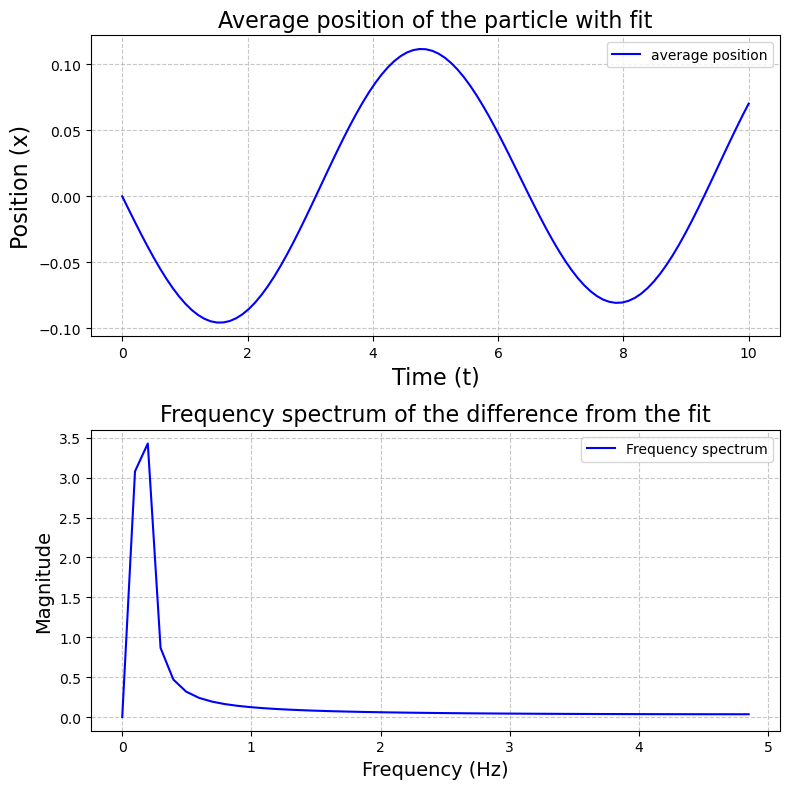

In [7]:
time = np.linspace(0, par.tsim, len(avg_position))

diff = avg_position - fitted_curve

freq, fft_magnitude = anim.analyze_spectrum(time, diff, filename)

In [8]:
filename = f"n={n}_real_T={tsim}.gif"
anim.gif_animation(par, density, potential, avg_position, n, filename)

Animation saved as 'n=0_real_T=10.gif'


## Imaginary time evolution

In [9]:
# SIMULATION PARAMETERS
im_time = True

In [10]:
# Initialize the Param object
par = fu.Param(xmin, xmax, num_x, tsim, num_t, im_time)


# Initialize the Operators object
opr = fu.Operators(res, voffset, wfcoffset, omega, order, n, q0_func, par)

In [11]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 0.5000000000000099


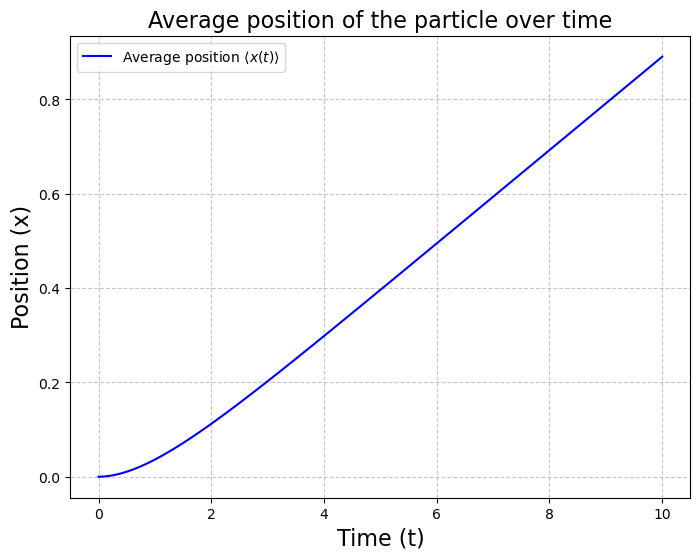

In [12]:
# Run the simulation and get the results
density, potential, avg_position = fu.split_op(par, opr)

filename = f"n={n}_imag_T={tsim}.png"

popt, fitted_curve = anim.plot_average_position(par, avg_position, n, filename, im_time)

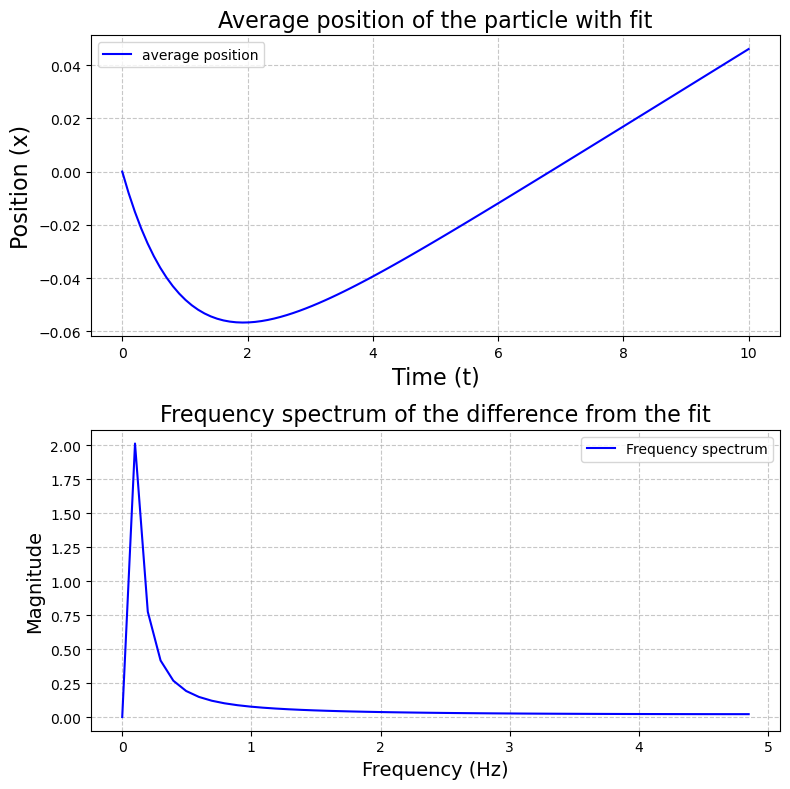

In [13]:
time = np.linspace(0, par.tsim, len(avg_position))

diff = avg_position - fitted_curve

freq, fft_magnitude = anim.analyze_spectrum(time, diff, filename)

In [14]:
filename = f"n={n}_imag_T={tsim}.gif"

anim.gif_animation(par, density, potential, avg_position, n, filename)

Animation saved as 'n=0_imag_T=10.gif'
